## Set up libraries etc

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import os
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score, adjusted_rand_score
from kneed import KneeLocator

## Read your credentials for accessing the COVID database from a file
* In general, personal credentials should never be included in a code file that you will share

## Read the data

In [2]:
person_data = pd.read_csv("data_covid.csv")
person_data

,person_id,cov_dt,category,race_name,gen_name,current_age,measurement_name,measurement_date,value_as_number,unit_name
0,68,2020-03-14,mild,White,MALE,72.0,Body temperature,2020-03-14,41.0,degree Celsius
1,68,2020-03-14,mild,White,MALE,72.0,Diastolic blood pressure,2020-03-14,76.0,millimeter mercury column
2,68,2020-03-14,mild,White,MALE,72.0,Heart rate,2020-03-14,139.8,per minute
3,68,2020-03-14,mild,White,MALE,72.0,Body weight,2020-03-14,86.1,kilogram
4,68,2020-03-14,mild,White,MALE,72.0,Systolic blood pressure,2020-03-14,135.0,millimeter mercury column
...,...,...,...,...,...,...,...,...,...,...
219917,124140,2020-03-16,moderate,White,FEMALE,65.0,Body weight,2020-03-21,65.9,kilogram
219918,124140,2020-03-16,moderate,White,FEMALE,65.0,Systolic blood pressure,2020-03-21,119.0,millimeter mercury column
219919,124140,2020-03-16,moderate,White,FEMALE,65.0,Oxygen saturation in Arterial blood,2020-03-21,76.9,percent
219920,124140,2020-03-16,moderate,White,FEMALE,65.0,Respiratory rate,2020-03-21,27.2,per minute


## How many patients?

In [3]:
print(f"Number of patients = {len(person_data['person_id'].unique())}")
print(f"Number of patients with mild covid = {len(person_data[person_data['category'] == 'mild']['person_id'].unique())}")
print(f"Number of patients with moderate covid = {len(person_data[person_data['category'] == 'moderate']['person_id'].unique())}")
print(f"Number of patients with severe covid = {len(person_data[person_data['category'] == 'severe']['person_id'].unique())}")

Number of patients = 1763
Number of patients with mild covid = 1003
Number of patients with moderate covid = 541
Number of patients with severe covid = 219


## How many unique categories are there?

In [4]:
uniq_cats = person_data['category'].unique()
print(f"Number of unique categories = {len(uniq_cats)}")
print(uniq_cats)

Number of unique categories = 3
['mild' 'moderate' 'severe']


## How many measurements are there in each of the categories?

In [5]:
mild_count = len(person_data[person_data['category'] == 'mild'])
print(f"Number of records with mild COVID is {mild_count}")

moderate_count = len(person_data[person_data['category'] == 'moderate'])
print(f"Number of records with moderate COVID is {moderate_count}")  

severe_count = len(person_data[person_data['category'] == 'severe'])
print(f"Number of records with severe COVID is {severe_count}") 

total_count = len(person_data)
print(f"Number of records with severe COVID is {total_count}") 

Number of records with mild COVID is 7430
Number of records with moderate COVID is 139518
Number of records with severe COVID is 72974
Number of records with severe COVID is 219922


## How many unique types of labs/vitals?

In [6]:
labs_vitals = person_data['measurement_name'].unique()
print(f"Number of Labs and Vitals = {len(labs_vitals)}")
print(labs_vitals)

Number of Labs and Vitals = 22
['Body temperature' 'Diastolic blood pressure' 'Heart rate' 'Body weight'
 'Systolic blood pressure' 'Oxygen saturation in Arterial blood'
 'Respiratory rate' 'Erythrocytes [#/volume] in Blood by Automated count'
 'Hemoglobin [Mass/volume] in Blood'
 'Hematocrit [Volume Fraction] of Blood by Automated count'
 'MCHC [Mass/volume] by Automated count'
 'Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (MDRD)'
 'Protein [Mass/volume] in Serum or Plasma'
 'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma'
 'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma'
 'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma'
 'Leukocytes [#/volume] in Blood by Automated count'
 'MCV [Entitic volume] by Automated count'
 'MCH [Entitic mass] by Automated count'
 'Platelets [#/volume] in Blood by Automated count'
 'Albumin [Mass/volume] in Serum

## Create a summary table

In [7]:
# Create a summary table of the patients
# Select demographic information of patients
person_demog = person_data[['person_id', 'category', 'race_name', 'gen_name', 'current_age']].drop_duplicates()
# Create bins for the age
bins=[0, 18, 46, 66, np.inf]
labels=['<18', '18-45', '46-65', '>65']
person_demog['age_group'] = pd.cut(person_demog['current_age'], bins=bins, labels=labels, right=False)
person_demog
# Count patients by category
person_demog_count_by_category = person_demog.groupby('category').size()
person_demog_count_by_category_format = person_demog_count_by_category.apply(lambda x: f"n={x:,}") #format the values
person_demog_count_by_category_format
# Create column headers
column_headers = list(map(lambda x: str.capitalize(x[0])+' COVID\nn='+f"{x[1]:,}",zip(person_demog_count_by_category.index.values,person_demog_count_by_category.values)))
# Count patients by category and sex
person_demog_count_by_category_sex = person_demog.groupby(['category', 'gen_name']).size()
person_demog_count_by_category_sex_percent = (person_demog_count_by_category_sex/person_demog_count_by_category) 
s1 = pd.Series(map(lambda x:f"{x[0]:,}({x[1]*100:.0f}%)", zip(person_demog_count_by_category_sex, person_demog_count_by_category_sex_percent)), index=person_demog_count_by_category_sex.index)  
# Count patients by category and age
person_demog_count_by_category_age = person_demog.groupby(['category', 'age_group']).size().rename("Count_by_cat_age")
person_demog_count_by_category_age_percent = (person_demog_count_by_category_age/person_demog_count_by_category).rename("Percent_by_cat_age")
s2 = pd.Series(map(lambda x:f"{x[0]:,}({x[1]*100:.0f}%)", zip(person_demog_count_by_category_age, person_demog_count_by_category_age_percent)), index=person_demog_count_by_category_age.index)  
# Count patients by category and race
person_demog_count_by_category_race = person_demog.groupby(['category', 'race_name']).size().rename("Count_by_cat_race")
person_demog_count_by_category_race_percent = (person_demog_count_by_category_race/person_demog_count_by_category).rename("Percent_by_cat_race")
s3 = pd.Series(map(lambda x:f"{x[0]:,}({x[1]*100:.0f}%)", zip(person_demog_count_by_category_race, person_demog_count_by_category_race_percent)), index=person_demog_count_by_category_race.index)
# Convert the categories as column and create multiindex
df1, df2, df3 = s1.unstack(level=0), s2.unstack(level=0), s3.unstack(level=0)
df1.index.name, df2.index.name, df3.index.name  = 'sex', 'age', 'race' 
df1.index = pd.MultiIndex.from_tuples([(df1.index.name,str.lower(i)) for i in df1.index.values])
df2.index = pd.MultiIndex.from_tuples([(df2.index.name,str.lower(i)) for i in df2.index.values])
df3.index = pd.MultiIndex.from_tuples([(df3.index.name,str.lower(i)) for i in df3.index.values])
# Combine all
full_table = pd.concat([df1, df2, df3])
# Change the columns to Multiindex
full_table.columns = pd.MultiIndex.from_tuples([tuple(i.split('\n')) for i in column_headers])
# Display the summary table
display(full_table)

Mild COVID Moderate COVID Severe COVID
                                  n=1,003          n=541        n=219
sex  female                      518(52%)       299(55%)      92(42%)
     male                        485(48%)       242(45%)     127(58%)
age  <18                         186(19%)         35(6%)        2(1%)
     18-45                       403(40%)       159(29%)       14(6%)
     46-65                       234(23%)       204(38%)      62(28%)
     >65                         180(18%)       143(26%)     141(64%)
race asian                         57(6%)         40(7%)       17(8%)
     black or african american   113(11%)         38(7%)       12(5%)
     no matching concept            7(1%)          6(1%)          NaN
     white                       826(82%)       457(84%)     190(87%)

## Add a column to the data frame that has the number of days since the index date
* Let us call this column `ddays`

### Convert the date columns to date_time objects from strings
* It is a lot easier to compute date differences that way

#### First confirm that the dates in `person_data` are indeed strings

In [8]:
person_data.dtypes

person_id             int64
cov_dt               object
category             object
race_name            object
gen_name             object
current_age         float64
measurement_name     object
measurement_date     object
value_as_number     float64
unit_name            object
dtype: object

In [9]:
type(person_data['cov_dt'])

pandas.core.series.Series

In [10]:
type(person_data.iloc[0]['cov_dt'])

str

#### Let us change the dates in `person_data` to be of type date_time

In [11]:
person_data["measurement_date"] = pd.to_datetime(person_data["measurement_date"])
type(person_data.iloc[0]["measurement_date"])

pandas._libs.tslibs.timestamps.Timestamp

In [12]:
person_data["cov_dt"] = pd.to_datetime(person_data["cov_dt"])
type(person_data.iloc[0]["cov_dt"])

pandas._libs.tslibs.timestamps.Timestamp

#### Add a column to `person_data` that is the difference in days between the `measurement_date` and `cov_dt`

In [13]:
person_data['ddays'] = (person_data["measurement_date"] - person_data["cov_dt"])
type(person_data.iloc[0]["ddays"])

pandas._libs.tslibs.timedeltas.Timedelta

In [14]:
person_data

,person_id,cov_dt,category,race_name,gen_name,current_age,measurement_name,measurement_date,value_as_number,unit_name,ddays
0,68,2020-03-14,mild,White,MALE,72.0,Body temperature,2020-03-14,41.0,degree Celsius,0 days
1,68,2020-03-14,mild,White,MALE,72.0,Diastolic blood pressure,2020-03-14,76.0,millimeter mercury column,0 days
2,68,2020-03-14,mild,White,MALE,72.0,Heart rate,2020-03-14,139.8,per minute,0 days
3,68,2020-03-14,mild,White,MALE,72.0,Body weight,2020-03-14,86.1,kilogram,0 days
4,68,2020-03-14,mild,White,MALE,72.0,Systolic blood pressure,2020-03-14,135.0,millimeter mercury column,0 days
...,...,...,...,...,...,...,...,...,...,...,...
219917,124140,2020-03-16,moderate,White,FEMALE,65.0,Body weight,2020-03-21,65.9,kilogram,5 days
219918,124140,2020-03-16,moderate,White,FEMALE,65.0,Systolic blood pressure,2020-03-21,119.0,millimeter mercury column,5 days
219919,124140,2020-03-16,moderate,White,FEMALE,65.0,Oxygen saturation in Arterial blood,2020-03-21,76.9,percent,5 days
219920,124140,2020-03-16,moderate,White,FEMALE,65.0,Respiratory rate,2020-03-21,27.2,per minute,5 days


#### `ddays` may not be usable as an index as it is. Let us make it of type iteger 

In [15]:
person_data['ddays'] = (person_data["measurement_date"] - person_data["cov_dt"]).dt.days
type(person_data.iloc[0]["ddays"])

numpy.int64

In [16]:
person_data

,person_id,cov_dt,category,race_name,gen_name,current_age,measurement_name,measurement_date,value_as_number,unit_name,ddays
0,68,2020-03-14,mild,White,MALE,72.0,Body temperature,2020-03-14,41.0,degree Celsius,0
1,68,2020-03-14,mild,White,MALE,72.0,Diastolic blood pressure,2020-03-14,76.0,millimeter mercury column,0
2,68,2020-03-14,mild,White,MALE,72.0,Heart rate,2020-03-14,139.8,per minute,0
3,68,2020-03-14,mild,White,MALE,72.0,Body weight,2020-03-14,86.1,kilogram,0
4,68,2020-03-14,mild,White,MALE,72.0,Systolic blood pressure,2020-03-14,135.0,millimeter mercury column,0
...,...,...,...,...,...,...,...,...,...,...,...
219917,124140,2020-03-16,moderate,White,FEMALE,65.0,Body weight,2020-03-21,65.9,kilogram,5
219918,124140,2020-03-16,moderate,White,FEMALE,65.0,Systolic blood pressure,2020-03-21,119.0,millimeter mercury column,5
219919,124140,2020-03-16,moderate,White,FEMALE,65.0,Oxygen saturation in Arterial blood,2020-03-21,76.9,percent,5
219920,124140,2020-03-16,moderate,White,FEMALE,65.0,Respiratory rate,2020-03-21,27.2,per minute,5


#### Do a quick check that the dataframe looks right

In [17]:
person_data.head()

,person_id,cov_dt,category,race_name,gen_name,current_age,measurement_name,measurement_date,value_as_number,unit_name,ddays
0,68,2020-03-14,mild,White,MALE,72.0,Body temperature,2020-03-14,41.0,degree Celsius,0
1,68,2020-03-14,mild,White,MALE,72.0,Diastolic blood pressure,2020-03-14,76.0,millimeter mercury column,0
2,68,2020-03-14,mild,White,MALE,72.0,Heart rate,2020-03-14,139.8,per minute,0
3,68,2020-03-14,mild,White,MALE,72.0,Body weight,2020-03-14,86.1,kilogram,0
4,68,2020-03-14,mild,White,MALE,72.0,Systolic blood pressure,2020-03-14,135.0,millimeter mercury column,0


## Create a dataframe for clustering on measurements (vitals and labs) by patient_id

#### Pick measurements for all of the 14 days of hospital visit 

In [18]:
# select the relevant columns
person_data_all = person_data[['person_id', 'measurement_name', 'value_as_number']]
print(person_data_all.head(20))
person_data_all['person_id'].unique().size

    person_id                     measurement_name  value_as_number
0          68                     Body temperature             41.0
1          68             Diastolic blood pressure             76.0
2          68                           Heart rate            139.8
3          68                          Body weight             86.1
4          68              Systolic blood pressure            135.0
5          68  Oxygen saturation in Arterial blood             86.0
6          68                     Respiratory rate             19.8
7         160              Systolic blood pressure            124.0
8         160                     Respiratory rate             31.1
9         160                     Body temperature             41.1
10        160                          Body weight             70.0
11        160  Oxygen saturation in Arterial blood             77.7
12        160                           Heart rate            100.5
13        160             Diastolic blood pressu

1763

#### Arrange records by person_id as index and the measurements as columns. Mean value was considered for more than one measurements.

In [19]:
person_data_all = pd.pivot_table(data=person_data_all, index='person_id', columns='measurement_name', values='value_as_number',
               aggfunc='mean')
person_data_all

measurement_name,Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma,Albumin [Mass/volume] in Serum or Plasma,Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma,Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma,Bilirubin.total [Mass/volume] in Serum or Plasma,Body temperature,Body weight,Diastolic blood pressure,Erythrocytes [#/volume] in Blood by Automated count,"Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (MDRD)",...,Hemoglobin [Mass/volume] in Blood,Leukocytes [#/volume] in Blood by Automated count,MCH [Entitic mass] by Automated count,MCHC [Mass/volume] by Automated count,MCV [Entitic volume] by Automated count,Oxygen saturation in Arterial blood,Platelets [#/volume] in Blood by Automated count,Protein [Mass/volume] in Serum or Plasma,Respiratory rate,Systolic blood pressure
person_id,,,,,,,,,,,,,,,,,,,,,
68,NaN,NaN,NaN,NaN,NaN,41.000000,86.1,76.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,86.000000,NaN,NaN,19.800000,135.000000
160,NaN,NaN,NaN,NaN,NaN,41.100000,70.0,74.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,77.700000,NaN,NaN,31.100000,124.000000
234,NaN,NaN,NaN,NaN,NaN,NaN,86.1,77.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,136.000000
259,NaN,NaN,NaN,NaN,NaN,38.400000,49.5,85.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,83.700000,NaN,NaN,16.100000,115.000000
296,NaN,NaN,NaN,NaN,NaN,38.600000,75.6,83.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,82.500000,NaN,NaN,22.900000,110.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123690,16.362500,4.368750,75.318750,22.0375,9.50,39.688235,79.1,82.941176,4.631250,10.287500,...,12.493750,3.443750,28.900000,34.031250,86.131250,82.090909,121.906250,6.587500,25.017647,125.176471
123828,55.800000,3.600000,62.000000,10.5000,1.00,38.200000,93.7,73.500000,NaN,43.750000,...,NaN,NaN,NaN,NaN,NaN,85.400000,NaN,70.400000,19.500000,122.500000
123856,NaN,NaN,NaN,NaN,NaN,40.100000,11.2,80.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,78.000000,NaN,NaN,16.200000,137.000000


#### Assign abbreviated column names to columns

In [20]:
column_names = {'Body temperature': 'Body temp',
 'Diastolic blood pressure': 'DBP',
 'Heart rate':  'HR',
 'Body weight': 'BW',
 'Systolic blood pressure': 'SBP',
 'Oxygen saturation in Arterial blood': 'SaO2',
 'Respiratory rate': 'RR',
 'Erythrocytes [#/volume] in Blood by Automated count': 'Erythrocytes',
 'Hemoglobin [Mass/volume] in Blood': 'Hemoglobin',
 'Hematocrit [Volume Fraction] of Blood by Automated count': 'Hematocrit',
 'MCHC [Mass/volume] by Automated count': 'MCHC',
 'Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (MDRD)': 'MDRD GFR',
 'Protein [Mass/volume] in Serum or Plasma': 'Protein',
 'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma': 'Alkaline phosphatase',
 'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma': 'Alanine aminotransferase',
 'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma': 'Aspartate aminotransferase',
 'Leukocytes [#/volume] in Blood by Automated count': 'Leukocytes',
 'MCV [Entitic volume] by Automated count': 'MCV',
 'MCH [Entitic mass] by Automated count': 'MCH',
 'Platelets [#/volume] in Blood by Automated count': 'Platelets',
 'Albumin [Mass/volume] in Serum or Plasma': 'Albumin',
 'Bilirubin.total [Mass/volume] in Serum or Plasma': 'Bilirubin.total'
}

print(len(column_names))

22


In [21]:
person_data_all.rename(columns=column_names, inplace=True)
person_data_all

measurement_name,Alanine aminotransferase,Albumin,Alkaline phosphatase,Aspartate aminotransferase,Bilirubin.total,Body temp,BW,DBP,Erythrocytes,MDRD GFR,...,Hemoglobin,Leukocytes,MCH,MCHC,MCV,SaO2,Platelets,Protein,RR,SBP
person_id,,,,,,,,,,,,,,,,,,,,,
68,NaN,NaN,NaN,NaN,NaN,41.000000,86.1,76.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,86.000000,NaN,NaN,19.800000,135.000000
160,NaN,NaN,NaN,NaN,NaN,41.100000,70.0,74.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,77.700000,NaN,NaN,31.100000,124.000000
234,NaN,NaN,NaN,NaN,NaN,NaN,86.1,77.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,136.000000
259,NaN,NaN,NaN,NaN,NaN,38.400000,49.5,85.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,83.700000,NaN,NaN,16.100000,115.000000
296,NaN,NaN,NaN,NaN,NaN,38.600000,75.6,83.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,82.500000,NaN,NaN,22.900000,110.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123690,16.362500,4.368750,75.318750,22.0375,9.50,39.688235,79.1,82.941176,4.631250,10.287500,...,12.493750,3.443750,28.900000,34.031250,86.131250,82.090909,121.906250,6.587500,25.017647,125.176471
123828,55.800000,3.600000,62.000000,10.5000,1.00,38.200000,93.7,73.500000,NaN,43.750000,...,NaN,NaN,NaN,NaN,NaN,85.400000,NaN,70.400000,19.500000,122.500000
123856,NaN,NaN,NaN,NaN,NaN,40.100000,11.2,80.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,78.000000,NaN,NaN,16.200000,137.000000


## Handle the missing values

#### Count the percentage of missing values in each column

In [22]:
num_of_patients = person_data_all.shape[0] #Total patients
num_of_measurements = person_data_all.shape[1] # Total measurement types
print(round(person_data_all.isna().sum()*100/num_of_patients,2))

measurement_name
Alanine aminotransferase      56.95
Albumin                       56.95
Alkaline phosphatase          56.95
Aspartate aminotransferase    56.95
Bilirubin.total               56.95
Body temp                      0.28
BW                             0.00
DBP                            0.00
Erythrocytes                  57.01
MDRD GFR                      56.44
HR                             0.00
Hematocrit                    57.01
Hemoglobin                    57.01
Leukocytes                    57.01
MCH                           57.01
MCHC                          57.01
MCV                           57.01
SaO2                           0.28
Platelets                     57.01
Protein                       56.95
RR                             0.00
SBP                            0.00
dtype: float64


There are 1763 patients with measurements for 22 vitals and labs. And for these patients the missing records are almost 57% for significant number of labs and vitals.

#### Impute with mean measurement along the column

In [23]:
person_data_all_imputed = person_data_all.fillna(person_data_all.mean())

In [24]:
# Check if all the null values have been replaced with its respective column's mean
print(person_data_all_imputed.isna().sum())
# Check the first 10 records
print(person_data_all_imputed.head(10))

measurement_name
Alanine aminotransferase      0
Albumin                       0
Alkaline phosphatase          0
Aspartate aminotransferase    0
Bilirubin.total               0
Body temp                     0
BW                            0
DBP                           0
Erythrocytes                  0
MDRD GFR                      0
HR                            0
Hematocrit                    0
Hemoglobin                    0
Leukocytes                    0
MCH                           0
MCHC                          0
MCV                           0
SaO2                          0
Platelets                     0
Protein                       0
RR                            0
SBP                           0
dtype: int64
measurement_name  Alanine aminotransferase   Albumin  Alkaline phosphatase  \
person_id                                                                    
68                               22.091924  4.503426             77.959802   
160                             

## Classification of the data into clusters

#### Scale the columns

In [25]:
scale = StandardScaler()
features_scaled = scale.fit_transform(person_data_all_imputed)
print(features_scaled.shape)

(1763, 22)


#### Find the number of principle components that preserves 80% of the variance in the data

In [26]:
pca = PCA()
_ = pca.fit(features_scaled)

Text(0.5, 1.0, 'Explained Variance by Components')

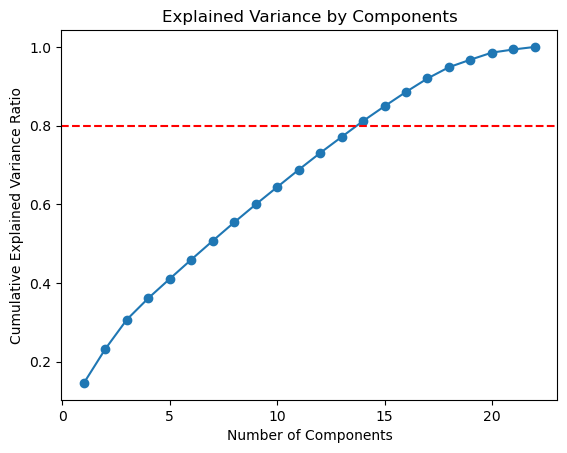

In [27]:
plt.plot(range(1,num_of_measurements+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.axhline(y=0.8, ls='--', c='r')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance by Components')

#### Around 13 components are enough to explain the variance of the data. So the number of components (n_components) kept is 13. 

In [28]:
pca = PCA(n_components=13)
features_sc_pca = pca.fit_transform(features_scaled)

#### Apply Kmeans Clustering and find the optimal number of cluster using SSE

In [29]:
kmeans_kwargs = {
    "init":'k-means++',
    "n_init":10,
    "tol":1e-04, 
    "max_iter":300, 
    "random_state":0 
}

sum_of_sq_dist = []
for k in range(1,30):
    km = KMeans(n_clusters = k, **kmeans_kwargs)
    km.fit(features_sc_pca)
    sum_of_sq_dist.append(km.inertia_)

Text(0, 0.5, 'Sum of Square Distance')

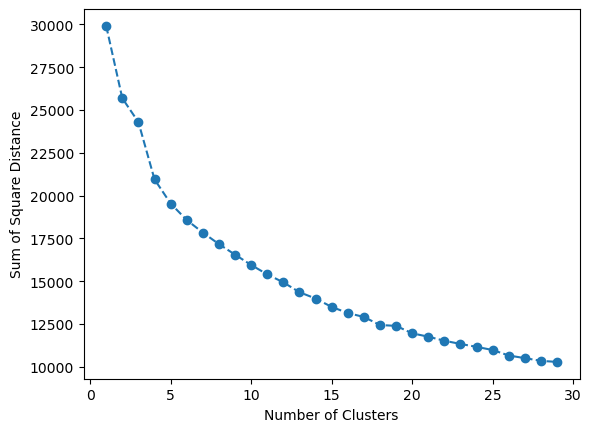

In [30]:
plt.plot(range(1,30), sum_of_sq_dist, marker='o', ls='--'  )
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Square Distance')

Optimized number of clusters:7


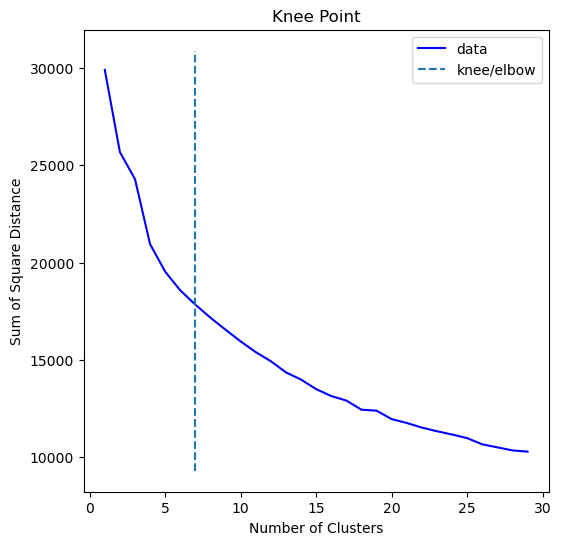

In [31]:
kneeloc = KneeLocator(range(1,30), sum_of_sq_dist, curve='convex', direction='decreasing')
print(f"Optimized number of clusters:{kneeloc.elbow}")
kneeloc.plot_knee()
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Square Distance')
plt.show()

The optimal number of clusters for the data is 7. Since we are mainly interested in two clusters (mild vs medium and severe) and 3 clusters (mild vs moderate vs severe), we will ignore the result of the optimization and run Kmeans for 2 and 3 clusters only. 

#### Apply Kmeans Clustering and find the optimal number of cluster using Silhouette coefficient

In [32]:
# Start from 2 clusters for silhouette score
silhouette_coefficients = []
for k in range(2,30):
    km = KMeans(n_clusters = k, **kmeans_kwargs)
    km.fit(features_sc_pca)
    score = silhouette_score(features_sc_pca,km.labels_)
    silhouette_coefficients.append(score)

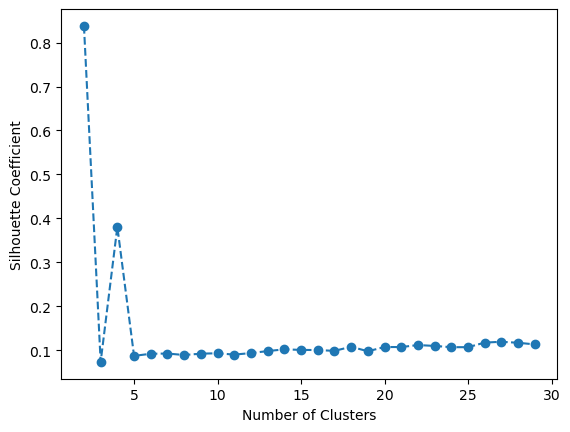

In [33]:
plt.plot(range(2,30), silhouette_coefficients, marker='o', ls='--'  )
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

The Silhouette coefficients lies in the range -1,1. The ideal value is close to 1. The best choice for the number of clusters is 2. But there is a possibility of 4 clusters. 

#### Kmeans for 2 clusters and evaluation by SSE and silhoutte score

In [34]:
km_k2 = KMeans(n_clusters = 2, **kmeans_kwargs)
km_k2.fit(features_sc_pca)
score = silhouette_score(features_sc_pca, km_k2.labels_)
print(f"The lowest SSE for 2 clusters is:{round(km_k2.inertia_,2)}")
print(f"The silhouette coefficient is:{round(score,2)}")
print(f"The locations of the centroids are:\n{km_k2.cluster_centers_}")
print(f"The number of iterations required to converge is:{km_k2.n_iter_}")


The lowest SSE for 2 clusters is:25685.19
The silhouette coefficient is:0.84
The locations of the centroids are:
[[-8.95605105e-02 -3.80027010e-02  4.65806658e-04 -6.60027641e-03
   1.22240888e-05 -1.38001660e-03  4.03294636e-03  7.58967935e-05
  -9.70825313e-05 -3.32027773e-03 -5.17004529e-04 -2.45898247e-03
   1.71683800e-03]
 [ 2.24668938e+01  9.53324900e+00 -1.16850927e-01  1.65572648e+00
  -3.06649999e-03  3.46187022e-01 -1.01169340e+00 -1.90392528e-02
   2.43538464e-02  8.32915386e-01  1.29694279e-01  6.16853317e-01
  -4.30681075e-01]]
The number of iterations required to converge is:4


#### Kmeans for 3 clusters and evaluation by SSE and silhoutte score

In [35]:
km_k3 = KMeans(n_clusters = 3, init='k-means++', n_init=10, tol=1e-04, max_iter=300, random_state=0)
km_k3.fit(features_sc_pca)
score = silhouette_score(features_sc_pca, km_k3.labels_)
print(f"The lowest SSE for 3 clusters is:{round(km_k3.inertia_,2)}")
print(f"The silhouette coefficient is:{round(score,2)}")
print(f"The locations of the centroids are:\n{km_k3.cluster_centers_}")
print(f"The number of iterations required to converge is:{km_k3.n_iter_}")

The lowest SSE for 3 clusters is:24291.67
The silhouette coefficient is:0.07
The locations of the centroids are:
[[-1.24081367e-01  1.01535546e-01 -4.43150539e-01 -8.65255739e-02
  -6.62636806e-02  3.75187735e-02  5.15505467e-01 -9.03467495e-02
  -2.23537399e-01  7.61266529e-03  8.96878077e-02  1.20392748e-01
   9.49762028e-03]
 [-1.44872650e-01 -9.79568073e-02  5.99849947e-01  1.15537744e-01
   1.09072974e-01 -5.21399746e-02 -6.88719349e-01  1.14302742e-01
   3.06925751e-01 -6.34369955e-03 -1.28910218e-01 -1.57587363e-01
  -1.36089303e-02]
 [ 1.78963607e+01 -2.22045463e+00 -1.97301474e-01  5.23476531e-02
  -1.14151566e+00  9.44286520e-02 -2.90988841e-01  4.18330069e-01
  -3.48850909e-01 -2.23901238e-01  4.70804893e-01 -2.54934331e-01
   4.74347127e-02]]
The number of iterations required to converge is:15


#### Kmeans for 4 clusters and evaluation by SSE and silhoutte score

In [36]:
km_k4 = KMeans(n_clusters = 4, init='k-means++', n_init=10, tol=1e-04, max_iter=300, random_state=0)
km_k4.fit(features_sc_pca)
score = silhouette_score(features_sc_pca, km_k4.labels_)
print(f"The lowest SSE for 3 clusters is:{round(km_k4.inertia_,2)}")
print(f"The silhouette coefficient is:{round(score,2)}")
print(f"The locations of the centroids are:\n{km_k4.cluster_centers_}")
print(f"The number of iterations required to converge is:{km_k4.n_iter_}")

The lowest SSE for 3 clusters is:20949.96
The silhouette coefficient is:0.38
The locations of the centroids are:
[[-1.30667307e-01  2.04908256e-02 -2.25465191e-01  1.28125841e-03
   1.36445830e-02 -1.68191305e-02 -9.75950739e-03  7.62496805e-03
   1.62794473e-02  5.47212577e-03 -1.33916873e-02  5.00436974e-04
   2.02276542e-02]
 [ 2.24668938e+01  9.53324900e+00 -1.16850927e-01  1.65572648e+00
  -3.06649999e-03  3.46187022e-01 -1.01169340e+00 -1.90392528e-02
   2.43538464e-02  8.32915386e-01  1.29694279e-01  6.16853317e-01
  -4.30681075e-01]
 [-1.86013172e-01 -7.66346550e-02  5.29021542e+00 -3.93120986e-02
  -1.11887592e-01  3.74929562e-01  2.79990394e-01 -2.53235934e-01
  -3.16414594e-01 -8.71043187e-02  2.27094274e-01  3.43668481e-02
  -4.79981319e-01]
 [ 1.25640722e+01 -1.59331089e+01 -2.91160444e-01 -1.81826098e+00
  -2.46970635e+00 -1.99289446e-01  5.49833146e-01  9.28594277e-01
  -7.84256457e-01 -1.45685396e+00  8.68767276e-01 -1.27201992e+00
   6.05236466e-01]]
The number of iter

#### Compare the KMeans labels with the true labels usign adjusted rand index (ARI)

In [37]:
y_label = person_data[['person_id','category']].drop_duplicates()
y_label

,person_id,category
0,68,mild
7,160,mild
14,234,mild
19,259,moderate
26,296,mild
...,...,...
219183,123690,severe
219558,123828,mild
219578,123856,mild
219585,124032,mild


In [38]:
y_label = y_label.set_index('person_id')

In [39]:
# Associate the patient with their respective category
df =person_data_all_imputed.join(y_label)
# Get the true y_labels
y_label = df['category']

In [40]:
y_label.value_counts()

mild        1003
moderate     541
severe       219
Name: category, dtype: int64

In [41]:
# Create a target with two categories by combining moderate and severe into non-mild
y_label_2cat = y_label.replace({'moderate':'non-mild', 'severe':'non-mild'})

In [42]:
# Encode the 3 categories target variable
# Encode the true labels and save in y_label_3cat_encoded
le_3cat = LabelEncoder()
y_label_3cat_encoded = le_3cat.fit_transform(y_label)
print(f"The categories are: {le_3cat.classes_}")
print(y_label_3cat_encoded)

The categories are: ['mild' 'moderate' 'severe']
[0 0 0 ... 0 0 1]


In [43]:
# Encode the 2 categories target variable
# Encode the true labels and save in y_label_2cat_encoded
le_2cat = LabelEncoder()
y_label_2cat_encoded = le_2cat.fit_transform(y_label_2cat)
print(f"The categories are: {le_2cat.classes_}")
print(y_label_2cat_encoded)

The categories are: ['mild' 'non-mild']
[0 0 0 ... 0 0 1]


In [44]:
# Compute the ARI score of Kmeans for 2 clusters 
ari_2 = adjusted_rand_score(y_label_2cat_encoded, km_k2.labels_)
# Compute the ARI score of Kmeans for 3 clusters 
ari_3 = adjusted_rand_score(y_label_3cat_encoded, km_k3.labels_)
print(f"The ARI score of kmeans for 2 clusters:{round(ari_2,2)}")
print(f"The ARI score of kmeans for 3 clusters:{round(ari_3,2)}")

The ARI score of kmeans for 2 clusters:-0.0
The ARI score of kmeans for 3 clusters:0.01


In [45]:
km_k2.labels_[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
y_label_2cat_encoded[:20]

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0])

ARI score close to zero implies that cluster labels are assigned randomly using KMeans for 2 as well as 3 clusters. 

## Create a summary table of 2 clusters

In [47]:
# Create a summary table of the patients
# Select demographic information of patients
person_demog = person_data[['person_id', 'race_name', 'gen_name', 'current_age']].drop_duplicates()
person_demog.set_index('person_id', inplace=True)
# Combine the cluster type with the demographic information
# Add Cluster label as a column named 'Cluster'
person_data_all_imputed['Cluster'] = km_k2.labels_
combined_labeled_df = person_demog.join(person_data_all_imputed)
df = person_demog.join(combined_labeled_df['Cluster'])
df
# Group by the cluster and create a summary table 
cluster_summary = df.groupby('Cluster').agg(
    n=pd.NamedAgg(column='Cluster', aggfunc='size'),
    Age = pd.NamedAgg(column='current_age', aggfunc=lambda x: f"{np.mean(x):.1f} {chr(177)} {np.std(x):.1f}"),
    Female = pd.NamedAgg(column='gen_name', aggfunc=lambda x: f"{sum(x=='FEMALE')}\
    ({sum(x=='FEMALE')*100/np.size(x):.1f}%)"),
    White = pd.NamedAgg(column='race_name', aggfunc=lambda x: f"{sum(x=='White')}\
    ({sum(x=='White')*100/np.size(x):.1f}%)"),
    Black = pd.NamedAgg(column='race_name', aggfunc=lambda x: f"{sum(x=='Black or African American')}\
    ({sum(x=='Black or African American')*100/np.size(x):.1f}%)"),
    Asian = pd.NamedAgg(column='race_name', aggfunc=lambda x: f"{sum(x=='Asian')}\
    ({sum(x=='Asian')*100/np.size(x):.1f}%)"),
    Other = pd.NamedAgg(column='race_name', aggfunc=lambda x: f"{sum(x=='No matching concept')}\
    ({sum(x=='No matching concept')*100/np.size(x):.1f}%)")        
)
# Create summary table of the overall data       
overall_summary = {}
overall_summary['n'] = [df.shape[0]]
overall_summary['Age'] = [f"{df.current_age.sum()/df.shape[0]:.1f} {chr(177)} {df.current_age.std():.1f}"]
overall_summary['Female'] = [f"{(df.gen_name == 'FEMALE').sum()} ({(df.gen_name == 'FEMALE').sum()*100/df.shape[0]:.1f}%)"]
overall_summary['White'] = [f"{(df.race_name == 'White').sum()} ({(df.race_name == 'White').sum()*100/df.shape[0]:.1f}%)"]
overall_summary['Black'] = [f"{(df.race_name == 'Black or African American').sum()}\
    ({(df.race_name == 'Black or African American').sum()*100/df.shape[0]:.1f}%)"]
overall_summary['Asian'] = [f"{(df.race_name == 'Asian').sum()}\
    ({(df.race_name == 'Asian').sum()*100/df.shape[0]:.1f}%)"]
overall_summary['Other'] = [f"{(df.race_name == 'No matching concept').sum()}\
    ({(df.race_name == 'No matching concept').sum()*100/df.shape[0]:.1f}%)"]
# Combine the two summary tables
cluster_summaryT = cluster_summary.transpose()
overall_summaryT = pd.DataFrame.from_dict(overall_summary).transpose()
pd.DataFrame.from_dict(overall_summary)
overall_summaryT = overall_summaryT.rename(columns={0:'Overall'})
display(overall_summaryT.join(cluster_summaryT))












,Overall,0,1
n,1763,1756,7
Age,48.4 ± 25.0,48.4 ± 25.0,42.1 ± 23.6
Female,909 (51.6%),905 (51.5%),4 (57.1%)
White,1473 (83.6%),1466 (83.5%),7 (100.0%)
Black,163 (9.2%),163 (9.3%),0 (0.0%)
Asian,114 (6.5%),114 (6.5%),0 (0.0%)
Other,13 (0.7%),13 (0.7%),0 (0.0%)


## Create a summary table of 3 clusters

In [48]:
# Create a summary table of the patients
# Select demographic information of patients
person_demog = person_data[['person_id', 'race_name', 'gen_name', 'current_age']].drop_duplicates()
person_demog.set_index('person_id', inplace=True)
# Combine the cluster type with the demographic information
# Add Cluster label as a column named 'Cluster'
person_data_all_imputed['Cluster'] = km_k3.labels_
combined_labeled_df = person_demog.join(person_data_all_imputed)
df = person_demog.join(combined_labeled_df['Cluster'])
df
# Group by the cluster and create a summary table 
cluster_summary = df.groupby('Cluster').agg(
    n=pd.NamedAgg(column='Cluster', aggfunc='size'),
    Age = pd.NamedAgg(column='current_age', aggfunc=lambda x: f"{np.mean(x):.1f} {chr(177)} {np.std(x):.1f}"),
    Female = pd.NamedAgg(column='gen_name', aggfunc=lambda x: f"{sum(x=='FEMALE')}\
    ({sum(x=='FEMALE')*100/np.size(x):.1f}%)"),
    White = pd.NamedAgg(column='race_name', aggfunc=lambda x: f"{sum(x=='White')}\
    ({sum(x=='White')*100/np.size(x):.1f}%)"),
    Black = pd.NamedAgg(column='race_name', aggfunc=lambda x: f"{sum(x=='Black or African American')}\
    ({sum(x=='Black or African American')*100/np.size(x):.1f}%)"),
    Asian = pd.NamedAgg(column='race_name', aggfunc=lambda x: f"{sum(x=='Asian')}\
    ({sum(x=='Asian')*100/np.size(x):.1f}%)"),
    Other = pd.NamedAgg(column='race_name', aggfunc=lambda x: f"{sum(x=='No matching concept')}\
    ({sum(x=='No matching concept')*100/np.size(x):.1f}%)")        
)
# Create summary table of the overall data       
overall_summary = {}
overall_summary['n'] = [df.shape[0]]
overall_summary['Age'] = [f"{df.current_age.sum()/df.shape[0]:.1f} {chr(177)} {df.current_age.std():.1f}"]
overall_summary['Female'] = [f"{(df.gen_name == 'FEMALE').sum()} ({(df.gen_name == 'FEMALE').sum()*100/df.shape[0]:.1f}%)"]
overall_summary['White'] = [f"{(df.race_name == 'White').sum()} ({(df.race_name == 'White').sum()*100/df.shape[0]:.1f}%)"]
overall_summary['Black'] = [f"{(df.race_name == 'Black or African American').sum()}\
    ({(df.race_name == 'Black or African American').sum()*100/df.shape[0]:.1f}%)"]
overall_summary['Asian'] = [f"{(df.race_name == 'Asian').sum()}\
    ({(df.race_name == 'Asian').sum()*100/df.shape[0]:.1f}%)"]
overall_summary['Other'] = [f"{(df.race_name == 'No matching concept').sum()}\
    ({(df.race_name == 'No matching concept').sum()*100/df.shape[0]:.1f}%)"]
# Combine the two summary tables
cluster_summaryT = cluster_summary.transpose()
overall_summaryT = pd.DataFrame.from_dict(overall_summary).transpose()
pd.DataFrame.from_dict(overall_summary)
overall_summaryT = overall_summaryT.rename(columns={0:'Overall'})
display(overall_summaryT.join(cluster_summaryT))












,Overall,0,1,2
n,1763,1004,746,13
Age,48.4 ± 25.0,44.6 ± 26.1,53.3 ± 22.2,61.2 ± 29.2
Female,909 (51.6%),532 (53.0%),371 (49.7%),6 (46.2%)
White,1473 (83.6%),838 (83.5%),623 (83.5%),12 (92.3%)
Black,163 (9.2%),96 (9.6%),67 (9.0%),0 (0.0%)
Asian,114 (6.5%),62 (6.2%),52 (7.0%),0 (0.0%)
Other,13 (0.7%),8 (0.8%),4 (0.5%),1 (7.7%)


## Create a summary table of 4 clusters

In [49]:
# Create a summary table of the patients
# Select demographic information of patients
person_demog = person_data[['person_id', 'race_name', 'gen_name', 'current_age']].drop_duplicates()
person_demog.set_index('person_id', inplace=True)
# Combine the cluster type with the demographic information
# Add Cluster label as a column named 'Cluster'
person_data_all_imputed['Cluster'] = km_k4.labels_
combined_labeled_df = person_demog.join(person_data_all_imputed)
df = person_demog.join(combined_labeled_df['Cluster'])
df
# Group by the cluster and create a summary table 
cluster_summary = df.groupby('Cluster').agg(
    n=pd.NamedAgg(column='Cluster', aggfunc='size'),
    Age = pd.NamedAgg(column='current_age', aggfunc=lambda x: f"{np.mean(x):.1f} {chr(177)} {np.std(x):.1f}"),
    Female = pd.NamedAgg(column='gen_name', aggfunc=lambda x: f"{sum(x=='FEMALE')}\
    ({sum(x=='FEMALE')*100/np.size(x):.1f}%)"),
    White = pd.NamedAgg(column='race_name', aggfunc=lambda x: f"{sum(x=='White')}\
    ({sum(x=='White')*100/np.size(x):.1f}%)"),
    Black = pd.NamedAgg(column='race_name', aggfunc=lambda x: f"{sum(x=='Black or African American')}\
    ({sum(x=='Black or African American')*100/np.size(x):.1f}%)"),
    Asian = pd.NamedAgg(column='race_name', aggfunc=lambda x: f"{sum(x=='Asian')}\
    ({sum(x=='Asian')*100/np.size(x):.1f}%)"),
    Other = pd.NamedAgg(column='race_name', aggfunc=lambda x: f"{sum(x=='No matching concept')}\
    ({sum(x=='No matching concept')*100/np.size(x):.1f}%)")        
)
# Create summary table of the overall data       
overall_summary = {}
overall_summary['n'] = [df.shape[0]]
overall_summary['Age'] = [f"{df.current_age.sum()/df.shape[0]:.1f} {chr(177)} {df.current_age.std():.1f}"]
overall_summary['Female'] = [f"{(df.gen_name == 'FEMALE').sum()} ({(df.gen_name == 'FEMALE').sum()*100/df.shape[0]:.1f}%)"]
overall_summary['White'] = [f"{(df.race_name == 'White').sum()} ({(df.race_name == 'White').sum()*100/df.shape[0]:.1f}%)"]
overall_summary['Black'] = [f"{(df.race_name == 'Black or African American').sum()}\
    ({(df.race_name == 'Black or African American').sum()*100/df.shape[0]:.1f}%)"]
overall_summary['Asian'] = [f"{(df.race_name == 'Asian').sum()}\
    ({(df.race_name == 'Asian').sum()*100/df.shape[0]:.1f}%)"]
overall_summary['Other'] = [f"{(df.race_name == 'No matching concept').sum()}\
    ({(df.race_name == 'No matching concept').sum()*100/df.shape[0]:.1f}%)"]
# Combine the two summary tables
cluster_summaryT = cluster_summary.transpose()
overall_summaryT = pd.DataFrame.from_dict(overall_summary).transpose()
pd.DataFrame.from_dict(overall_summary)
overall_summaryT = overall_summaryT.rename(columns={0:'Overall'})
display(overall_summaryT.join(cluster_summaryT))












,Overall,0,1,2,3
n,1763,1678,7,72,6
Age,48.4 ± 25.0,47.9 ± 24.9,42.1 ± 23.6,58.2 ± 21.8,83.5 ± 16.6
Female,909 (51.6%),870 (51.8%),4 (57.1%),33 (45.8%),2 (33.3%)
White,1473 (83.6%),1405 (83.7%),7 (100.0%),56 (77.8%),5 (83.3%)
Black,163 (9.2%),155 (9.2%),0 (0.0%),8 (11.1%),0 (0.0%)
Asian,114 (6.5%),108 (6.4%),0 (0.0%),6 (8.3%),0 (0.0%)
Other,13 (0.7%),10 (0.6%),0 (0.0%),2 (2.8%),1 (16.7%)


## Create a bar graph of 2 clusters

In [50]:
has_value = person_data_all.notna()
has_value['Cluster'] = km_k2.labels_
for_bar_graph = has_value.groupby('Cluster').agg([lambda x: round(np.sum(x)*100/np.size(x),1)])

In [51]:
# Remove the 2nd level from the multiindex
for_bar_graph.columns = for_bar_graph.columns.droplevel(level=1)

In [52]:
for_bar_graph

measurement_name,Alanine aminotransferase,Albumin,Alkaline phosphatase,Aspartate aminotransferase,Bilirubin.total,Body temp,BW,DBP,Erythrocytes,MDRD GFR,...,Hemoglobin,Leukocytes,MCH,MCHC,MCV,SaO2,Platelets,Protein,RR,SBP
Cluster,,,,,,,,,,,,,,,,,,,,,
0,43.1,43.1,43.1,43.1,43.1,99.7,100.0,100.0,42.8,43.6,...,42.8,42.8,42.8,42.8,42.8,99.7,42.8,43.1,100.0,100.0
1,28.6,28.6,28.6,28.6,28.6,100.0,100.0,100.0,100.0,28.6,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,28.6,100.0,100.0


In [53]:
#Transfrom to create data for the barplot
df_bar = for_bar_graph.melt(ignore_index=False).reset_index()

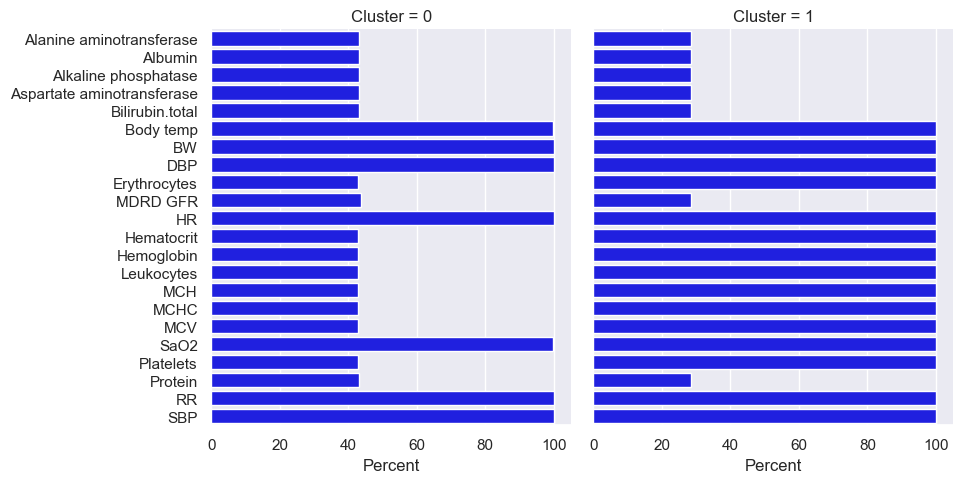

In [54]:
sns.set_theme()
g = sns.catplot(
    df_bar, kind="bar",
    y="measurement_name", x="value", col="Cluster", color="blue"
)
g.set_axis_labels("Percent", "")
plt.savefig('Case4Cluster2.jpg')
plt.show()

## Create a bar graph of 3 clusters

In [55]:
has_value = person_data_all.notna()
has_value['Cluster'] = km_k3.labels_
for_bar_graph = has_value.groupby('Cluster').agg([lambda x: round(np.sum(x)*100/np.size(x),1)])

In [56]:
# Remove the 2nd level from the multiindex
for_bar_graph.columns = for_bar_graph.columns.droplevel(level=1)

In [57]:
for_bar_graph

measurement_name,Alanine aminotransferase,Albumin,Alkaline phosphatase,Aspartate aminotransferase,Bilirubin.total,Body temp,BW,DBP,Erythrocytes,MDRD GFR,...,Hemoglobin,Leukocytes,MCH,MCHC,MCV,SaO2,Platelets,Protein,RR,SBP
Cluster,,,,,,,,,,,,,,,,,,,,,
0,38.6,38.6,38.6,38.6,38.6,99.9,100.0,100.0,38.6,38.9,...,38.6,38.6,38.6,38.6,38.6,99.9,38.6,38.6,100.0,100.0
1,48.7,48.7,48.7,48.7,48.7,99.5,100.0,100.0,48.7,49.5,...,48.7,48.7,48.7,48.7,48.7,99.5,48.7,48.7,100.0,100.0
2,61.5,61.5,61.5,61.5,61.5,100.0,100.0,100.0,53.8,61.5,...,53.8,53.8,53.8,53.8,53.8,100.0,53.8,61.5,100.0,100.0


In [58]:
#Transfrom to create data for the barplot
df_bar = for_bar_graph.melt(ignore_index=False).reset_index()

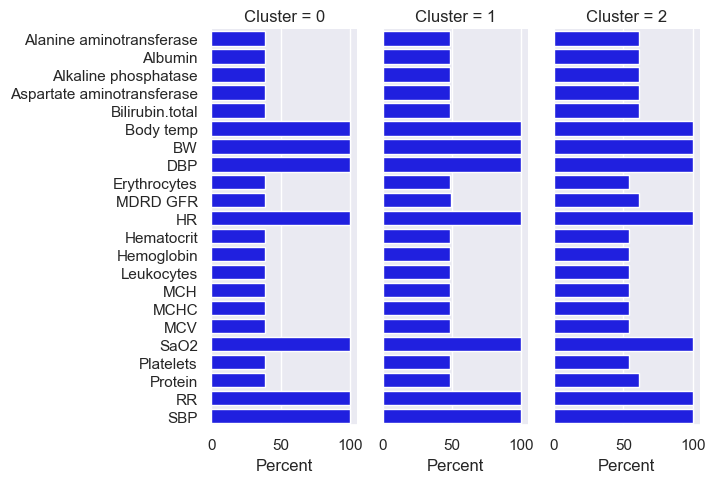

In [59]:
sns.set_theme()
g = sns.catplot(
    df_bar, kind="bar",
    y="measurement_name", x="value", col="Cluster", color="blue", aspect=0.5
)
g.set_axis_labels("Percent", "")
plt.savefig('Case4Cluster3.jpg')
plt.show()

## Create a bar graph of 4 clusters

In [60]:
has_value = person_data_all.notna()
has_value['Cluster'] = km_k4.labels_
for_bar_graph = has_value.groupby('Cluster').agg([lambda x: round(np.sum(x)*100/np.size(x),1)])

In [61]:
# Remove the 2nd level from the multiindex
for_bar_graph.columns = for_bar_graph.columns.droplevel(level=1)

In [62]:
for_bar_graph

measurement_name,Alanine aminotransferase,Albumin,Alkaline phosphatase,Aspartate aminotransferase,Bilirubin.total,Body temp,BW,DBP,Erythrocytes,MDRD GFR,...,Hemoglobin,Leukocytes,MCH,MCHC,MCV,SaO2,Platelets,Protein,RR,SBP
Cluster,,,,,,,,,,,,,,,,,,,,,
0,42.3,42.3,42.3,42.3,42.3,99.7,100.0,100.0,42.3,42.8,...,42.3,42.3,42.3,42.3,42.3,99.7,42.3,42.3,100.0,100.0
1,28.6,28.6,28.6,28.6,28.6,100.0,100.0,100.0,100.0,28.6,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,28.6,100.0,100.0
2,56.9,56.9,56.9,56.9,56.9,100.0,100.0,100.0,56.9,58.3,...,56.9,56.9,56.9,56.9,56.9,100.0,56.9,56.9,100.0,100.0
3,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,100.0,100.0,100.0


In [63]:
#Transfrom to create data for the barplot
df_bar = for_bar_graph.melt(ignore_index=False).reset_index()

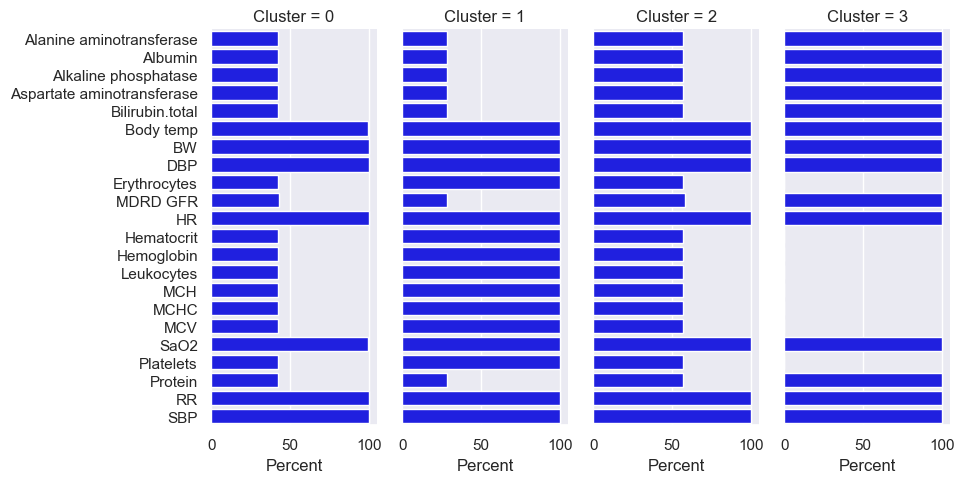

In [64]:
g = sns.catplot(
    df_bar, kind="bar",
    y="measurement_name", x="value", col="Cluster", color="blue", aspect=0.5
)
g.set_axis_labels("Percent", "")
plt.savefig('Case4Cluster4.jpg')
plt.show()